In [1]:
#load necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import h5py

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

/home/apurvnit/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]               
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches





In [4]:
# train = pd.read_csv('../input/sign_mnist_train.csv')
# test = pd.read_csv('../input/sign_mnist_train.csv')

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


In [5]:
print(X_test_orig.shape, X_train_orig.shape)
print(Y_train_orig.shape)

(120, 64, 64, 3) (1080, 64, 64, 3)
(1, 1080)


# OneHotEncoding
It puts 1 on the index of the current label we are accessing , say if the image is for a fist it will create a array of 24 elements and all values would be 0 except 5th position whose value would be 1 .

In [6]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [7]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

This simple histogram shows the count of images of gestures in the training data for each number. This graphic is used to visualize if there is an unequal sample size among the digits. The sample size for each digit appear to be comparable. There is no issue of unequal sampling.

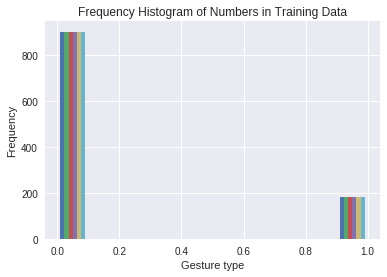

In [8]:
import matplotlib.pyplot as plt
plt.hist(Y_train)
plt.title("Frequency Histogram of Numbers in Training Data")
plt.xlabel("Gesture type")
plt.ylabel("Frequency")

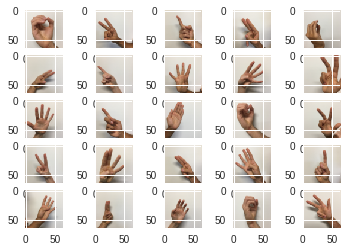

In [9]:
import math
# plot the first 25 images in the training set. 
f, ax = plt.subplots(5, 5)
# plot some 4s as an example
for i in range(1,26):
    data = X_train_orig[i] #this is the first number
    nrows, ncols = 64,64
    grid = data.reshape((nrows, ncols, 3))
    n=math.ceil(i/5)-1
    m=[0,1,2,3,4]*5
    ax[m[i-1], n].imshow(grid)

# Normalization
The dataset we already have is in grayscale i.e only 2-d vector(but flattened) . Now we are gonna normalize data for comparison. 

In [10]:
def normalization(x, mu, sigma):
    return (x-mu)/sigma

In [11]:
mu = np.mean(X_train_orig, axis=0)
sigma = np.max(X_train_orig, axis=0)-np.min(X_train_orig, axis=0)+1e-20

In [12]:
test = normalization(X_test_orig, mu, sigma)
X_train = normalization(X_train_orig, mu, sigma)

In [13]:
print("the train pixels lie between %.2f to %.2f" % (np.min(np.min(X_train)), np.max(np.max(X_train))))

the train pixels lie between -0.95 to 0.63


In [14]:
print(Y_train.shape)

(1080, 6)


In [15]:
print(X_train.shape)

(1080, 64, 64, 3)


# Creating Model
using resnet-50 which has 50 layers and is used to predict much complex features in an image


In [16]:
def identity_block(X, f, filters, stage, block):

    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [17]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f), strides=(1,1), name=conv_name_base+'2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s),padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    
    X =  X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [18]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [19]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
import time

print("==================================================") 
    
print("Creating Model At: ","model.json") 
start_time = time.time()

plot_model(model, to_file='model.png', show_shapes= True, show_layer_names = True)

json_model = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(json_model)

end_time = time.time()
total_time = end_time-start_time
print("Model Created: ",total_time, " seconds")

print("==================================================")

Creating Model At:  model.json
Model Created:  4.290692329406738  seconds


In [26]:
# !pip install pydot - done this for training on kaggle
print(model)
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes= True, show_layer_names = True)

In [27]:
model.load_weights('hand_detection_weights.h5')

In [28]:

model.fit(X_train, Y_train, epochs = 10, batch_size = 32,validation_split=0.2)
#     model.save_weights('hand_detection_weights.h5')

Train on 864 samples, validate on 216 samples
Epoch 1/10
864/864 [==============================] - 119s 138ms/step - loss: 0.0846 - acc: 0.9757 - val_loss: 0.3815 - val_acc: 0.8935
Epoch 2/10
864/864 [==============================] - 116s 134ms/step - loss: 0.0597 - acc: 0.9815 - val_loss: 0.3818 - val_acc: 0.9074
Epoch 3/10
864/864 [==============================] - 116s 134ms/step - loss: 0.0260 - acc: 0.9942 - val_loss: 0.1975 - val_acc: 0.9259
Epoch 4/10
864/864 [==============================] - 116s 134ms/step - loss: 0.0251 - acc: 0.9931 - val_loss: 0.3827 - val_acc: 0.9120
Epoch 5/10
864/864 [==============================] - 117s 135ms/step - loss: 0.1359 - acc: 0.9699 - val_loss: 0.4723 - val_acc: 0.8843
Epoch 6/10
864/864 [==============================] - 118s 137ms/step - loss: 0.1224 - acc: 0.9699 - val_loss: 0.3327 - val_acc: 0.9028
Epoch 7/10
864/864 [==============================] - 87s 101ms/step - loss: 0.0327 - acc: 0.9896 - val_loss: 0.3014 - val_acc: 0.9352
Epo

In [29]:
model.save_weights('hand_detection_weights.h5')

In [30]:
model.evaluate(test, Y_test)

120/120 [==============================] - 2s 19ms/step


[0.3389967362085978, 0.9416666706403096]